# TP3 Logistic Regression and SGD


### Table of Contents

* [1. Logistic Regression using Sklearn](#chapter1)
* [2. Gradient descent for Logistic Regression](#chapter2)
* [3. mini-batch SGD](#chapter3)
* [4. Logistic Regression for IRIS](#chapter4)
* [5. Logistic Regression for MNIST and CIFAR10](#chapter5)

## 0. Data preparation 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

First we will use simulated data : 

In [31]:
np.random.seed(12)
half_observation_number = 5000

rng = np.random.default_rng()
x1 = rng.multivariate_normal([0, 0], [[1, 0.75], [0.75, 1]], half_observation_number)
x2 = rng.multivariate_normal([0, 2.7], [[1, 0.75], [0.75, 1]], half_observation_number)

X = np.vstack((x1, x2)).astype(np.float32)
y = np.hstack((np.zeros(half_observation_number), np.ones(half_observation_number)))

print(X.shape)
print(y.shape)

(10000, 2)
(10000,)


*In the first three sections, we will focus solely on training the model. Therefore, we do not use a test set.* 

**Exercise 1** : How many features are there ? Is it a regression problem or a classification problem ?

There are `2` features and it is a classification problem.

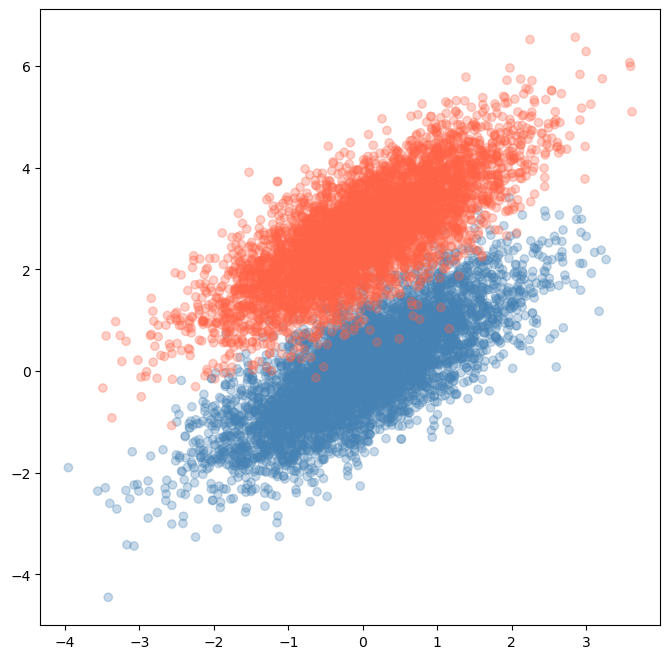

In [32]:
import matplotlib.colors as mcolors

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.3, cmap=mcolors.ListedColormap(["steelblue", "tomato"]))

**Exercise 2** : What is the parameter `c=y` used for ? (you can try the following code without  `c=y`). 
*Reference* : 
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

/var/folders/tp/_ld5_pzs6nx6mv1pbjhq1l740000gn/T/ipykernel_87821/1711589517.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:, 0], X[:, 1], alpha=0.3, cmap=mcolors.ListedColormap(["steelblue", "tomato"]))


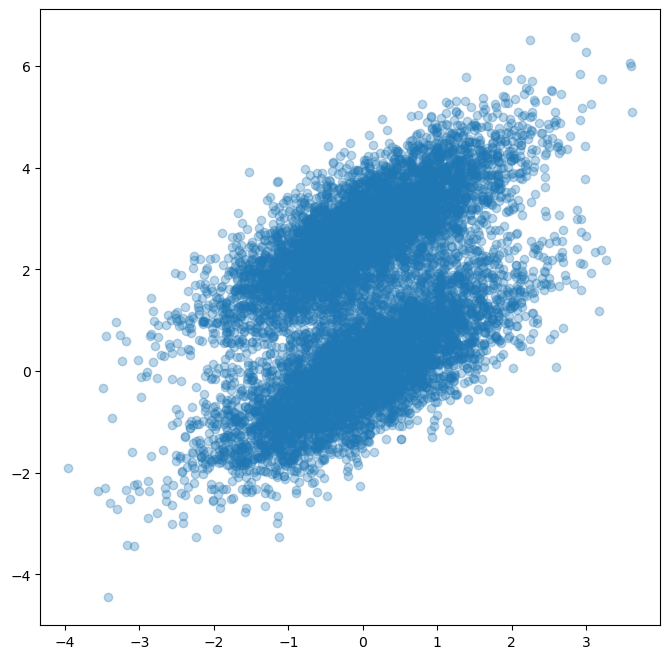

In [33]:
plt.figure(figsize=(8, 8))

plt.scatter(X[:, 0], X[:, 1], alpha=0.3, cmap=mcolors.ListedColormap(["steelblue", "tomato"]))

Answer for Exercise 2 :

`c=y` refers to the marker colors. The possible values are:
- A scalar or sequence of n numbers to be mapped to colors using cmap and norm.
- A 2D array in which the rows are RGB or RGBA.
- A sequence of colors of length n.
- A single color format string.




_____________

## 1. Logistic Regression in Sklearn<a class="anchor" id="chapter1"></a> 

Now let us fit a logistic regression model using `Sklearn`. 

*Reference* :

- `LogisticRegression` in `sklearn.linear_model` : 
https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression (Version 1.3)

- Cost function for  the logistic regression in  Sklearn : Section 1.1.11.1 of 
https://scikit-learn.org/dev/modules/linear_model.html#logistic-regression 

**Exercice 3** : Create a  logistic regression model, named  `Reglog`, using the parameters  `fit_intercept=True` and  `penalty=None`. 

- What does `fit_intercept=True` mean ?

- `C` is a regularization parameter (ridge). In order to use the usual (unpenalized) logistic regression, we can specify `penalty='none'`.   (Alternatively, one could use  a large enough parameter for penalization, e.g. C=1e15.) 

In [34]:
# Answer for Exercise 3
reg_log = LogisticRegression(penalty=None, fit_intercept=True)
reg_log

LogisticRegression(penalty=None)

**Exercise 4** : Fit the model `Reglog` on the data  `(X,y)`. 

In [35]:
# Answer for Exercise 4
reg_log.fit(X, y)

LogisticRegression(penalty=None)

**Exercise 5** : (1) Display the coefficients and the intercept. 

(2) Plot the decision boundary and the scatter plot on the same graph (x-axis scale : -4  to 4).

In [36]:
# Answer for Exercise 5 (1)
a1, a2 = reg_log.coef_[0]
b = reg_log.intercept_[0]

print("The coefficients are : ", a1, ",", a2)
print("The intercept is : ", b)

The coefficients are :  -4.698124406065196 , 6.213409207061598
The intercept is :  -8.346121222086511


We have $w^T * x + b = 0$

So, in dim=2, $w_1 * x_1 + w_2 * x_2 + b = 0$

Finally, $x_2 = - (w_1 * x_1 + b) / w_2$

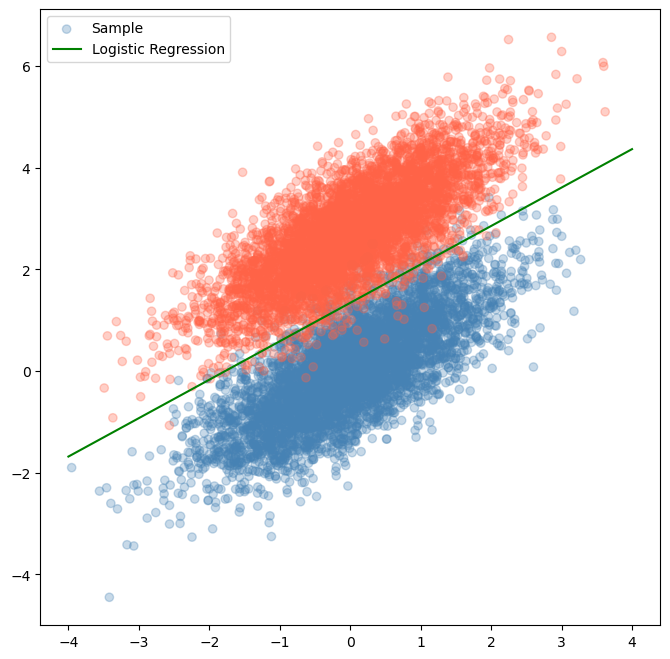

In [37]:
# Answer for Exercise 5 (2)
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.3, cmap=mcolors.ListedColormap(["steelblue", "tomato"]), label="Sample")

x1 = np.linspace(-4, 4, 100)
x2_learn = -(a1 * x1 + b) / a2  # Cf above
plt.plot(x1, x2_learn, label='Logistic Regression', c='green')
plt.legend()
plt.show()

_____________

## 2.  Gradient descent for  logistic regression <a class="anchor" id="chapter2"></a> 

Now let us  write the gradient descent algorithm for the logistic regression cost function.

**Exercise 6** : write a  function named  `sigmoid` (that obviously computes the sigmoid function) and plot the curve of  `sigmoid` on $[-7,7]$. 

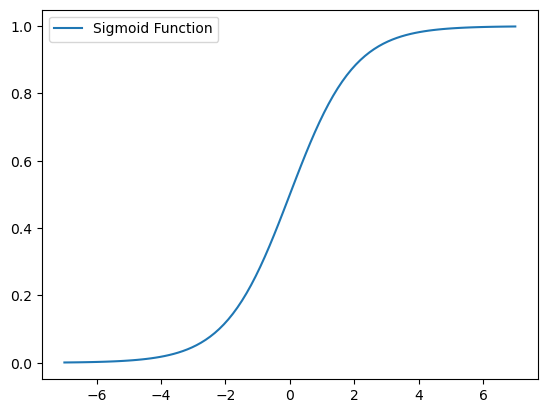

In [38]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


x = np.linspace(-7, 7, 100)
plt.plot(x, sigmoid(x), label="Sigmoid Function")
plt.legend()
plt.show()

**Exercise 7** : let $w$ denote as the weight vector and $b$ as the intercept.

Write the cost function of the logistic regression defined by  "$-$ log-likelihood" on the data `(X,y)` and name it `cost_log_likelihood`. 

In [39]:
def cost_log_likelihood(X, y, w, b):
    h = sigmoid(np.dot(X, w) + b)
    return -np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))

**Exercise 8** : write a function implementing the gradient descent algorithm for the logistic regression cost function. 

- Name this function `GD_training`. (`GD` is for `Gradient Descent`).

- The input of  `GD_training` will be 

  - the data `X,y`, 
       
  - the number of iterations  (num_steps)    
  - the  learning rate (learning_rate)

- We will initialize the paramaters as follows :  $w=(0,0)$ and $b=0$.


In [40]:
def GD_training(X, y, num_steps, learning_rate):
    w, b = np.zeros(2), 0

    for step in range(num_steps):
        h = sigmoid(np.dot(X, w) + b)

        grad_w = X.T @ (h - y)
        grad_b = np.sum(h - y)

        w -= learning_rate * grad_w
        b -= learning_rate * grad_b

        if step % 300 == 0:
            print("In step ", step, ", the parameters are ", w, b, ";")
            print("and the value of the cost function is ", cost_log_likelihood(X, y, w, b))

    return w, b

**Exercise 9** : Run the next cell. Compare the boundary decision we get using `Sklearn` (with the default algorithm) with the boundary we got using gradient descent. 

In [41]:
w_GD, b_GD = GD_training(X, y, num_steps=3000, learning_rate=5e-5)

print("The parameters are : ", w_GD, b_GD)

In step  0 , the parameters are  [0.00153647 0.33871266] 0.0 ;
and the value of the cost function is  5275.865698969024
In step  300 , the parameters are  [-2.34810353  3.25054244] -4.160290012659158 ;
and the value of the cost function is  756.3110375589763
In step  600 , the parameters are  [-2.8885127   3.91778361] -5.122316883530483 ;
and the value of the cost function is  641.7719246408615
In step  900 , the parameters are  [-3.21294809  4.32379939] -5.700307343788985 ;
and the value of the cost function is  600.9912201400733
In step  1200 , the parameters are  [-3.44249778  4.61299967] -6.109358690938331 ;
and the value of the cost function is  580.608497535862
In step  1500 , the parameters are  [-3.61767029  4.83459653] -6.421531380172041 ;
and the value of the cost function is  568.7388533903074
In step  1800 , the parameters are  [-3.75734136  5.01177289] -6.670433297857319 ;
and the value of the cost function is  561.1905874098641
In step  2100 , the parameters are  [-3.8719

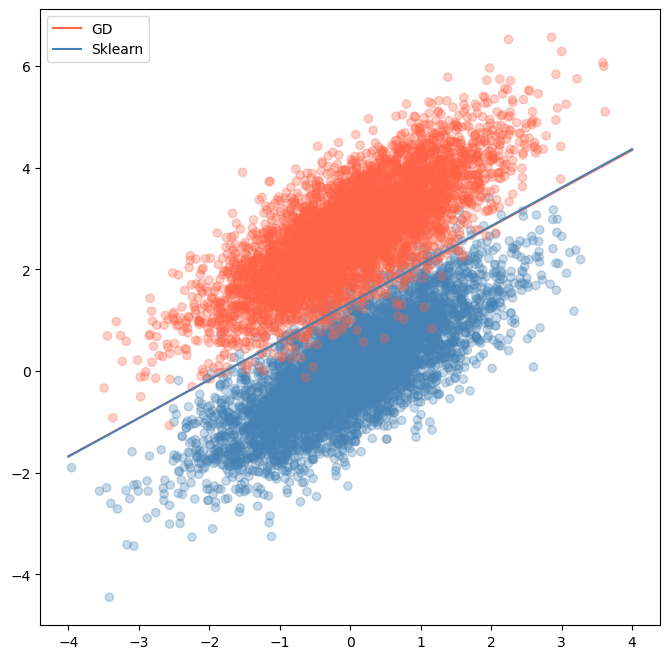

In [42]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.3, cmap=mcolors.ListedColormap(["steelblue", "tomato"]))

# Plot the decision boundaries 
# blue : the decision boundary using Sklearn
# rouge : the decision boundary using  GD 
x1 = np.linspace(-4, 4, 100)
x2_GD = -(w_GD[0] * x1 + b_GD) / w_GD[1]

plt.plot(x1, x2_GD, c="tomato", label="GD")
plt.plot(x1, x2_learn, c="steelblue", label="Sklearn")
plt.legend()
plt.show()


------------------------------

## 3. mini-batch SGD for the  logistic regression <a class="anchor" id="chapter3"></a> 

**Exercise 10** : write a function implementing  mini-batch SGD for the cost function of a  logistic regression. 

- Name this function `mini_batch_SGD`. `SGD` is short for  `Stochastic Gradient Descent`.

- the input will be 

  - the data `X,y`,   

  - the learning rate (learning_rate)
    
  - the mini-batch size (batch_size)
  
  - the number of epochs (epochs)

- Initialization :  $w=(0,0)$ et $b=0$.

- We add an output `costs_SGD`  to track the values of the cost function throughout the training process.

To simplify, you can assume that the sample size is a multiple of the batch size.  

Hint : you can use `np.random.default_rng.shuffle()` to shuffle the dataset (permutation) : https://numpy.org/doc/2.2/reference/random/generated/numpy.random.Generator.shuffle.html

Pay attention to the fact that you must sample non only `X` but also `y`.

In [43]:
a = np.arange(10)
rng = np.random.default_rng(seed=42)
rng.shuffle(a)  # shuffle in place
a

array([5, 6, 0, 7, 3, 2, 4, 9, 1, 8])

In [58]:
def mini_batch_SGD(X, y, learning_rate, batch_size, epochs):
    """
    Mini-batch stochastic gradient descent for logistic regression.

    Parameters:
        X (numpy.ndarray): Input data of shape (n, d), where n is the number of samples and d is the number of features.
        y (numpy.ndarray): Labels of shape (n,), where n is the sample size.
        learning_rate (float): Learning rate for gradient descent.
        batch_size (int): Size of each mini-batch.
        epochs (int): Number of epochs to train.
    
    Returns:
        w (numpy.ndarray): Final weight vector of shape (d,).
        b (float): Final bias term.
        costs_SGD (list): Cost function values at each step.
    """
    # Initialization
    n, d = X.shape
    w = np.zeros(d)
    b = 0
    costs_SGD = []

    for epoch in range(epochs):
        # Shuffle the data at the beginning of each epoch
        indices = np.arange(n)
        np.random.default_rng(seed=epoch).shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Mini-batch processing
        for i in range(0, n, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            # Compute predictions
            h = sigmoid(np.dot(X_batch, w) + b)

            # Compute gradients
            grad_w = (h - y_batch) @ X_batch
            grad_b = np.sum(h - y_batch)

            # Update parameters
            w -= learning_rate * grad_w
            b -= learning_rate * grad_b

            # Compute and store cost for tracking
            current_cost = cost_log_likelihood(X_batch, y_batch, w, b)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}, Cost: {current_cost:.4f}")
                print(" and the parameters are", w, b, ";")

            costs_SGD.append(current_cost)

    return w, b, costs_SGD

In [64]:
w_SGD, b_SGD, cost_SGD = mini_batch_SGD(X, y, learning_rate=5e-5, batch_size=50, epochs=1000)


Epoch 0/1000, Cost: 34.6290
 and the parameters are [-5.87201336e-05  1.17358307e-03] -0.0002 ;
Epoch 0/1000, Cost: 34.5887
 and the parameters are [-0.00027173  0.00251791] -0.00015089470314657126 ;
Epoch 0/1000, Cost: 34.5602
 and the parameters are [-0.00068416  0.00373089] -0.0003027243288860721 ;
Epoch 0/1000, Cost: 34.4884
 and the parameters are [-0.00047074  0.0053166 ] -0.0005054958950922852 ;
Epoch 0/1000, Cost: 34.3402
 and the parameters are [-0.00036129  0.00745055] -0.00040945684562978846 ;
Epoch 0/1000, Cost: 34.3860
 and the parameters are [-0.0005649  0.0089469] -0.00041479070720988186 ;
Epoch 0/1000, Cost: 34.2132
 and the parameters are [-0.00058962  0.0109634 ] -0.00032220667395566527 ;
Epoch 0/1000, Cost: 34.1200
 and the parameters are [-0.00057486  0.0130156 ] -8.34889460169458e-05 ;
Epoch 0/1000, Cost: 34.1005
 and the parameters are [-0.00066628  0.01486911] 5.620899842442194e-05 ;
Epoch 0/1000, Cost: 34.1125
 and the parameters are [-0.00081733  0.01649599] 9.

In [55]:
# when n//batch_size=0
x = np.array(['a', 'b', 'c', 'd', 'e', 'f'])
indices = np.array([0, 1, 2, 3, 4, 5])
n = len(x)
np.random.default_rng().shuffle(indices)
batch_size = 2
x_shuffled = x[indices]
j = 0
for i in range(0, n, batch_size):
    print(f"batch number {j}", x_shuffled[i:i + batch_size])
    j += 1

batch number 0 ['e' 'b']
batch number 1 ['a' 'd']
batch number 2 ['c' 'f']


In [56]:
#when n//batch_size different from zero. 
x = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
indices = np.array([0, 1, 2, 3, 4, 5, 6])
n = len(x)
np.random.default_rng().shuffle(indices)
batch_size = 2
x_shuffled = x[indices]
j = 0
for i in range(0, n, batch_size):
    print(f"batch number {j}", x_shuffled[i:i + batch_size])
    j += 1

batch number 0 ['a' 'g']
batch number 1 ['b' 'c']
batch number 2 ['f' 'e']
batch number 3 ['d']


**Exercise 11** : (1) Run the next cell 
- Remark : The  sample size here is 10,000. Here we choose the mini-batch size to be 1,000. $\Rightarrow$ At each iteration of SGD, we perform only 10% of the computations compared to standard gradient descent. 

- We can increase the `learning_rate` to `5e-4` to achieve faster convergence.

(2) Compare the boundary decisions that we get using   SGD with the boundary decision we get using `Sklearn`.

(3) Plot the curve of `costs_SGD`, what can be observed ?

In [66]:
w_SGD, b_SGD, costs_SGD = mini_batch_SGD(X, y, learning_rate=5e-4, batch_size=1000, epochs=30)

print("The parameters computed by stochastic gradient descent are: ", w_SGD, b_SGD)


Epoch 0/30, Cost: 517.4821
 and the parameters are [0.0100902  0.34872694] 0.0005 ;
Epoch 0/30, Cost: 481.5803
 and the parameters are [-0.02038284  0.49817735] -0.05840138420715016 ;
Epoch 0/30, Cost: 451.6845
 and the parameters are [-0.05604284  0.59840067] -0.12322652166577681 ;
Epoch 0/30, Cost: 427.9511
 and the parameters are [-0.09907442  0.67537289] -0.1920781407971993 ;
Epoch 0/30, Cost: 393.2649
 and the parameters are [-0.12768148  0.75186105] -0.25711154818603743 ;
Epoch 0/30, Cost: 379.5035
 and the parameters are [-0.16517607  0.80707822] -0.32320945265453194 ;
Epoch 0/30, Cost: 372.7068
 and the parameters are [-0.21037082  0.84940112] -0.39301979569594525 ;
Epoch 0/30, Cost: 352.3565
 and the parameters are [-0.24378167  0.89731213] -0.4539372118721294 ;
Epoch 0/30, Cost: 346.1305
 and the parameters are [-0.27733977  0.9315336 ] -0.5182412337372836 ;
Epoch 0/30, Cost: 344.1426
 and the parameters are [-0.32075489  0.95664215] -0.5869673362344282 ;
Epoch 10/30, Cost: 1

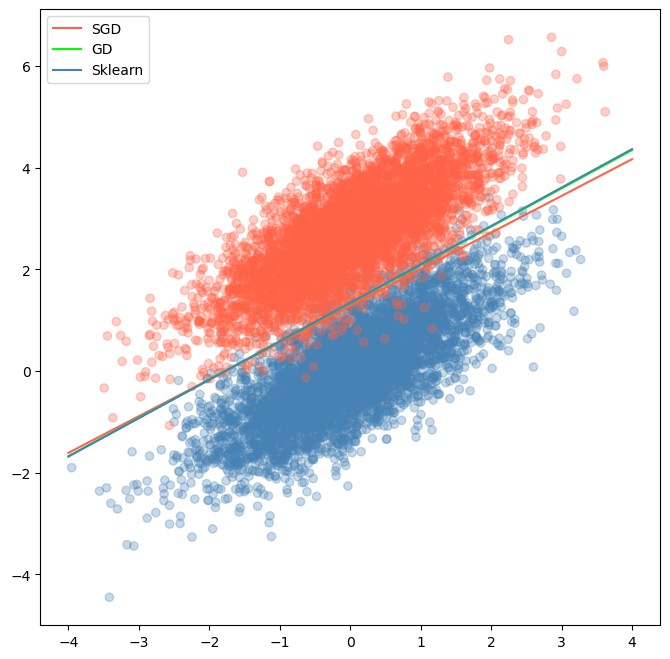

In [67]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.3, cmap=mcolors.ListedColormap(["steelblue", "tomato"]))

x1 = np.linspace(-4, 4, 100)
x2_SGD = -(w_SGD[0] * x1 + b_SGD) / w_SGD[1]

plt.plot(x1, x2_SGD, c="tomato", label="SGD")
plt.plot(x1, x2_GD, c="lime", label="GD")
plt.plot(x1, x2_learn, c="steelblue", label="Sklearn")
plt.legend()
plt.show()

## 4. Logistic Regression on IRIS

**Exercise 12**
Split the dataset IRIS into a training set and a test set (specifying a random_state=5), keeping 33% of the data for the test set, and then fit a logistic Regression model on the training set using `sklearn`. Compute the accuracy score on the test set. 

In [75]:
from sklearn.model_selection import train_test_split
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)

X, y = iris.data, iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)

log_reg = LogisticRegression(fit_intercept=True)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
log_reg.score(X_test, y_test)

0.98

## 5. Logistic Regression on MNIST and CIFAR-10

As these datasets are large (large sample size and high dimension), sklearn is not adapted (even if we try another solver than the default one...). That is why we will use `tensorflow` (and more precisely `keras`) to fit a logistic regression model on MNIST and CIFAR10. Indeed tensorflow is  for neural networks but, as mentioned in the lecture notes, logistic regression can be considered a particular neural network :

![assets/log-reg-nn.png](assets/log-reg-nn.png)

Here in the lecture notes, the *activation function* is the *sigmoid* function as the problem is assumed to be a *binary* classification problem. But logistic regression can be used for a multiclass problem (i.e. more than two labels) as well : see https://datax.berkeley.edu/wp-content/uploads/2020/09/slides-m140-logistic-reg-sklearn.pdf slides 22, 23 and 24. 

See also (if necessary) :  https://en.wikipedia.org/wiki/Multinomial_logistic_regression Section "As a set of independent binary regressions"

The softmax function : https://en.wikipedia.org/wiki/Softmax_function

So the multiclass logistic regression model, for $K$ labels in $\{1,2,\ldots,K\}$, assumes that there exists a set of coefficients $(w_k)_{1\le k<K}$ and a set of intercepts $(b_k)_{1\le k<K}$ (where, for all $k$, $w_k \in \mathbb{R}^p$ if there are $p$ features) $b_k \in \mathbb{R}$) such that :

 1. If $1\le k <K$ then $P(Y=k\vert X=x)=$ $\frac{\exp(w_k^Tx+b_k)}{1+\sum_{\ell=1}^{K-1}\exp(w_\ell^Tx+b_\ell) }$
 
 2. For k=K :  $P(Y=K\vert X=x)=$ $\frac{1}{1+\sum_{\ell=1}^{K-1}\exp(w_\ell^Tx+b_\ell) }$

In [1]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [2]:
type(x_train)

numpy.ndarray

In [3]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [4]:
28 * 28

784

So the image is not flattened ($28 \times 28$) and the sample size is 60000. Before feeding the data to a logistic regression model, we need to flatten the data : that is what the layer `Flatten`does : this layer turns a 2 dimensional array (of shape $28\times 28$) into a one-dimensional array (with 784 elements, so each of these 784 pixels is a feature). 

In [5]:
# definition of the model 
tf.random.set_seed(4)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=[28, 28]))  # we specify the input shape
model.add(tf.keras.layers.Flatten())  # we flatten the data
model.add(tf.keras.layers.Dense(10, activation="softmax"))  # 10 labels (figures from 0 to 9)
#activation="softmax" as it is a multiclass problem

Next we need to compile the model : this consists in specifying the loss used for the optimization problem, the optimizer, and the metrics. 

1. **The loss** (or cost function) is, as in the binary case, **minus the log-likelihood**. 

Let us recall that, in the binary case, the loss function is 
$$-l_{\mathcal{D}_n}\big(w,b\big)=-\sum_{1\leq i\leq n}\Big[Y_i\log\big(\sigma(X_i^Tw+b)\big)+(1-Y_i)\log \big(1-\sigma(X_i^Tw+b)\big)\Big].$$
i.e. 
$$-l_{\mathcal{D}_n}\big(w,b\big)=-\sum_{1\leq i\leq n}\Big[\mathbb{1}_{Y_i=1}\log\big(\sigma(X_i^Tw+b)\big)+\mathbb{1}_{Y_i=0}\log \big(1-\sigma(X_i^Tw+b)\big)\Big].$$


In the multiclass case, the loss function is :

$-l_{\mathcal{D}_n}\big((w_k)_{1\le k<K},(b_k)_{1\le k<K}\big)$
$$=-\sum_{i=1}^n\Big[ \sum_{k=1}^{K-1} \mathbb{1}_{Y_i=k}\log(\frac{\exp(w_k^Tx+b_k)}{1+\sum_{\ell=1}^{K-1}\exp(w_\ell^Tx+b_\ell) })+ \mathbb{1}_{Y_i=K}\log(\frac{1}{1+\sum_{\ell=1}^{K-1}\exp(w_\ell^Tx+b_\ell) })\Big]$$

Remark : in keras, when the labels are  provided as integers as it is the case here, this loss is called `sparse_categorical_crossentropy`. If you want to provide labels using one-hot representation ("dummy variables" https://en.wikipedia.org/wiki/Dummy_variable_(statistics)),  use `categorical_crossentropy`. 

 2. We use the stochastic gradient descent (SGD) for the optimizer.
 
 3. We can also measure the accuracy of the classifier during training (`metrics=["accuracy"]'). 

In [6]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [7]:
history = model.fit(x_train, y_train, epochs=30)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 398us/step - accuracy: 0.8051 - loss: 468.3519
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step - accuracy: 0.8693 - loss: 261.4901
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8733 - loss: 246.0638
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.8760 - loss: 243.4188
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step - accuracy: 0.8779 - loss: 233.7820
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - accuracy: 0.8788 - loss: 233.2691
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 858us/step - accuracy: 0.8817 - loss: 233.2722
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.8806 - loss: 231.9280
Epoch 9/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - accuracy: 0.8823 - loss: 230.8179
Epoch 10/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 0.8813 - loss: 229.9344
Epoch 11/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 431us/step - accuracy: 0.8828 - l

In [8]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - accuracy: 0.8769 - loss: 261.1911


[234.9829559326172, 0.8919000029563904]

**Exercise 13** Do the same with the dataset CIFAR10. (Also 10 labels)

In [9]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [12]:
len(np.unique(y_test))  # 10 labels

10

In [13]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))